Tesseract Overview
-----------------------

This notebook is supposed to provide a brief overview over the Tesseract framework (and might be later adapted to Transcend as well).


    ├── tesseract             <- Main folder
    │   ├── mock.py           <- Module for generating test distributions for use with Tesseract
    │   ├── evaluation.py     <- This is the class where the magic happens  ;)
    │   ├── metrics.py        <- Various methods to calculate and output metrics (including AUT)
    │   └── ...

**TODO**: Extend this description

## Running this Notebook 

1. Run `make data` to pull the necessary data files. 
2. Reproduce Drebin graph from paper (Figure 5)

---

In [2]:
import os
import json
import numpy as np
from datetime import datetime
from sklearn.feature_extraction import DictVectorizer

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_PATH = os.path.join(PROJ_ROOT, 'data', 'processed')

features_file, labels_file, meta_file = os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-X.json'), os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-Y.json'), os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-meta.json')

with open(features_file) as json_file:
    D = json.load(json_file)
    for datapoint in D:
        del datapoint['sha256']
    vec = DictVectorizer()  
    X = vec.fit_transform(D) # transform key-value (JSON) into sparse feature vector
    
with open(labels_file) as json_file:
    labels = json.load(json_file)
    y = np.array([l[0] for l in labels])
    
with open(meta_file) as json_file:
    meta = json.load(json_file)
    t = list()
    for m in meta:
        timestamp = datetime.strptime(m['dex_date'], '%Y-%m-%dT%H:%M:%S')
        t.append(timestamp)
    t = np.array(t)

In [62]:
from tesseract import evaluation, temporal, metrics, mock

# Partition dataset
splits = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

In [63]:
from sklearn.svm import LinearSVC

# Perform a timeline evaluation
clf = LinearSVC()
results_10 = evaluation.fit_predict_update(clf, *splits)
    
# View results 
metrics.print_metrics(results_10)
    
# View AUT(F1, 24 months) as a measure of robustness over time 
print(metrics.aut(results_10, 'f1'))

0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
24it [00:10,  2.21it/s]

------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24   
------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |    144    129    215    183    221    216    275    272    354    313    374    369    344    476    635    612    452    278    352    564    148     81     23      8
Actual neg  |   1564   1231   1888   1838   1953   2098   2521   2768   3077   2932   3010   3289   3478   3959   5818   6368   4052   2806   3027   4881   1377    758    190     67
Total       |   1708   1360   2103   2021   2174   2314   2796   3040   3431   3245   33

In [64]:
print(metrics.aut(results_10, 'f1'))

0.576516839563213


F1 AUT: 0.576516839563213
Recall AUT: 0.47822563106540306
Precision AUT: 0.7548889758446389


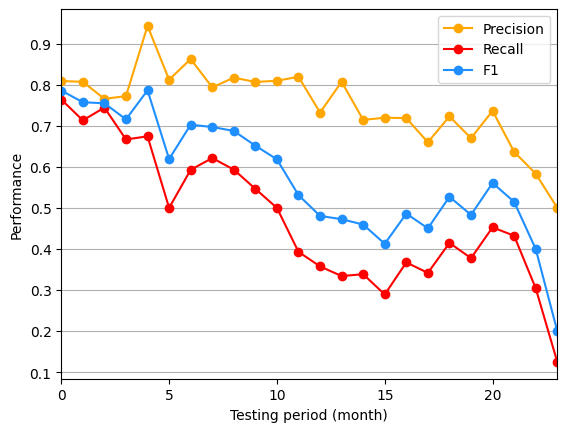

In [65]:
print(f"F1 AUT: {metrics.aut(results_10, 'f1')}")
print(f"Recall AUT: {metrics.aut(results_10, 'recall')}")
print(f"Precision AUT: {metrics.aut(results_10, 'precision')}")
#%%
from pylab import *

pendleblue='#1f8fff'
pendleyellow='#ffa600'

'#FF9999', '#FFDD99', '#AAEEEE'
plot(results_10['precision'], marker='o', color=pendleyellow)
plot(results_10['recall'], marker='o', color='red')
plot(results_10['f1'], marker='o', color=pendleblue)
legend(['Precision', 'Recall', 'F1'])
xlim([0,23])
xlabel('Testing period (month)')
ylabel('Performance')
grid(axis = 'y')

### Reproducing Figure 6

In [66]:
# Finding the optimal malware ratio in training data
from tesseract import spatial 

X_train, X_test, y_train, y_test, temp_train, temp_test = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

In [67]:
tp_list = results_10['tp']
tn_list = results_10['tn']
fp_list = results_10['fp']
fn_list = results_10['fn']

# Sum the lists
total_tp = sum(tp_list)
total_tn = sum(tn_list)
total_fp = sum(fp_list)
total_fn = sum(fn_list)

# Calculate accuracy
accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)
print(f"Overall Accuracy: {accuracy}")


Overall Accuracy: 0.9331555259209868


In [68]:
spatial_clf = LinearSVC()
optimal_malware_training_ratio, aut, error_rate = spatial.find_optimal_train_ratio(
    spatial_clf, 
    X_train, 
    y_train, 
    temp_train, 
    proper_train_size=8, # measured in units of `granularity`
    validation_size=2, 
    granularity="month", 
    start_tr_rate=0.1, # % of malware in training to start with
    acceptable_errors=0.1,
    end_tr_rate=0.5 # Stop at max 50% malware
)
print(f"Optimal malware training ratio: {optimal_malware_training_ratio}")

0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2it [00:05,  2.76s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2it [00:03,  1.89s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2it [00:03,  1.58s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-

Optimal malware training ratio: 0.1


In [69]:
spatial_clf = LinearSVC()
rates = spatial.search_optimal_train_ratio(
    spatial_clf, 
    X_train, 
    y_train, 
    temp_train, 
    proper_train_size=8, # measured in units of `granularity`
    validation_size=2, 
    granularity="month", 
    start_tr_rate=0.1, # % of malware in training to start with
    end_tr_rate=0.5 # Stop at max 50% malware
)

0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2it [00:05,  2.99s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2it [00:03,  1.83s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2it [00:02,  1.43s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-

In [70]:
import pandas as pd 

rates = pd.DataFrame(rates)
rates

,errors,auts,phis,fn,fp,total
0,0.029601,0.792940,0.10,271.0,144.0,14020.0
1,0.031669,0.782587,0.15,256.0,188.0,14020.0
2,0.031027,0.790091,0.20,243.0,192.0,14020.0
3,0.033024,0.784783,0.25,218.0,245.0,14020.0
4,0.033880,0.771641,0.30,222.0,253.0,14020.0
5,0.037233,0.773343,0.35,197.0,325.0,14020.0
6,0.040585,0.759497,0.40,203.0,366.0,14020.0
7,0.039230,0.773563,0.45,169.0,381.0,14020.0
8,0.048502,0.730529,0.50,176.0,504.0,14020.0


Okay, now we figured out that the AUT score is the highest with a malware percentage of 25%. So we can retrain our classifier with 25% of malware in the training data. 

In [71]:
# Redo splitting
X_train, X_test, y_train, y_test, temp_train, temp_test = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

# Downsample so that there's 25% malware in the training data
train_idxs = spatial.downsample_to_rate(y_train, 0.25)

X_train = X_train[train_idxs]
y_train = y_train[train_idxs]
temp_train = temp_train[train_idxs]

In [72]:
# Train a new classifier 
clf = LinearSVC() 
results_25 = evaluation.fit_predict_update(clf, X_train, X_test, y_train, y_test, temp_train, temp_test)

0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
24it [00:04,  5.03it/s]


In [73]:
metrics.print_metrics(results_25)

print(metrics.aut(results_25, 'f1'))

------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24   
------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |    144    129    215    183    221    216    275    272    354    313    374    369    344    476    635    612    452    278    352    564    148     81     23      8
Actual neg  |   1564   1231   1888   1838   1953   2098   2521   2768   3077   2932   3010   3289   3478   3959   5818   6368   4052   2806   3027   4881   1377    758    190     67
Total       |   1708   1360   2103   2021   2174   2314   2796   3040   3431   3245   33

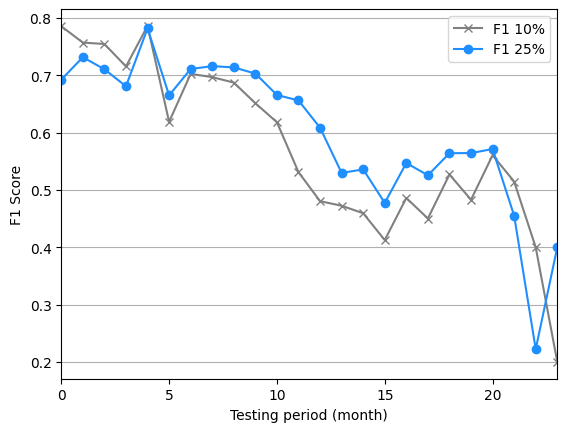

In [75]:
# Reproduce the plot 

plot(results_10['f1'], marker='x', color='gray')
plot(results_25['f1'], marker='o', color=pendleblue)
legend(['F1 10%', 'F1 25%'])
xlim([0, 23])
xlabel('Testing period (month)')
ylabel('F1 Score')
grid(axis = 'y')